Filtering articles 2023-2024 so gets qids of ones that actually ahve been viewed

In [1]:
import requests
import mwclient
import json, os
import csv
import pandas as pd
from io import StringIO
from datetime import datetime, timedelta

In [ ]:
daily_df = pd.read_csv("physics_pageviews.csv")
unique_qids = daily_df["qid"].unique()
unique_qids.size

unique_qids

4730

In [10]:
# This file was created iteratatively with Gemini and Google Colab over a series of multiple prompts.
# Here are the prompts
"""
Prompt 1: given the QID of a Wikipedia article, I want a python script that uses a python 
library wrapper to query Wikidata. My interest is to find out whether the page belongs to 
a human entity and if so, what is their gender or sex, their profession, and their date of 
birth. Can you write such a script. 

Prompt 2: This was great and it worked really well. I want now to focus on non-human entities. 
What kind of information I can get from the Wikidata page about such entities? To give you more 
context, I have access to Wikipedia pageviews data and I want to be able to say: pages about 
movies have more traffic than pages about sport events, or pages about science concepts are 
more popular than pages about historical events. Can you help extract meaningful data from 
the Wikidata page about non-humans? Create a new function about that. Imagine that we first 
check if a page is human or not, than if not human, call this function about the properties 
of such a page. 

Prompt 3: this works, are there any other attributes that can be added in addition to instance_of, 
country, and start date? 

Prompt 4: is there a dynamic way to get information? for example, is there a scraper of Wikidata? 
That is, if I go to this page: https://www.wikidata.org/wiki/Q83285, my scraper gives me a JSON 
of all attribute:values in the page. How is the HTML page created? Maybe data is passed as a 
JSON and we can use it directly. 

Prompt 5: now that I have the Property IDs for an entity in Wikidata, how do I get the corresponding
values of what they mean and what their values are for a given QID.

Prompt 6: okay, you got the names of the property IDs in the entry for the QID I provided you, 
but now I want to see their values, for example, what is the value for the P17 (country) for this 
QID, and so on. You'll need a second function to do this, at the end, I would like pairs like: 
"country": "Albania", "population": 113,249, and so on.
"""


import requests
import json, os

WIKIDATA_API_ENDPOINT = "https://www.wikidata.org/w/api.php"

def fetch_complete_entity_data(qid):
    """
    Fetches all available structured data for a single Wikidata entity (QID)
    using the official Wikibase API action=wbgetentities.

    Args:
        qid (str): The Wikidata Item ID (e.g., 'Q83285' for Durres).

    Returns:
        dict: The complete raw JSON data for the entity, or an error dictionary.
    """

    # Parameters for the MediaWiki API, using the 'wbgetentities' action
    params = {
        'action': 'wbgetentities',
        'ids': qid,
        'format': 'json',
        # Request all relevant data: claims (properties), labels, descriptions, sitelinks (Wikipedia links)
        'props': 'claims|labels|descriptions|sitelinks|aliases',
    }

    # Add a User-Agent header as recommended by Wikidata API policies
    # https://www.wikidata.org/wiki/Wikidata:Contact_the_development_team#User-Agent
    headers = {
        'User-Agent': 'Colab-Wikidata-Example/1.0 (https://colab.research.google.com; colab-user@example.com)'
    }

    try:
        response = requests.get(WIKIDATA_API_ENDPOINT, 
                                params=params, 
                                headers=headers, 
                                timeout=10)
        response.raise_for_status()  # Raises an HTTPError for bad responses (4xx or 5xx)

        data = response.json()

        # Check for potential errors in the API response structure
        if 'error' in data:
            return {"error": f"API Error for {qid}: {data['error']['info']}"}

        # The core data is nested under ['entities'][qid]
        entity_data = data.get('entities', {}).get(qid)

        if entity_data:
            return entity_data
        else:
            return {"error": f"Entity {qid} not found or no data returned."}

    except requests.exceptions.RequestException as e:
        return {"error": f"Network or API request error: {e}"}
    except json.JSONDecodeError:
        return {"error": "Failed to decode JSON response."}

def _chunk_list(lst, n):
    """
    Yields successive n-sized chunks from lst.
    """
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def fetch_labels_for_qids(qids: list[str], lang='en'):
    """
    Fetches labels for a list of Wikidata QIDs or Property IDs.
    Handles API limits by chunking the requests.

    Args:
        qids (list[str]): A list of Wikidata Item IDs or Property IDs (e.g., ['Q515', 'P31']).
        lang (str): The language code for the labels (default is 'en').

    Returns:
        dict: A dictionary mapping QID to its label, or an error dictionary.
    """
    if not qids:
        return {}

    # Wikidata API limit for 'ids' parameter is typically 50
    MAX_IDS_PER_REQUEST = 50
    all_labels_map = {}

    # Chunk the QID list to respect the API limit
    for qid_chunk in _chunk_list(qids, MAX_IDS_PER_REQUEST):
        params = {
            'action': 'wbgetentities',
            'ids': '|'.join(qid_chunk), # Join QIDs with '|' for multiple requests
            'format': 'json',
            'props': 'labels',
            'languages': lang,
        }

        headers = {
            'User-Agent': 'Colab-Wikidata-Example/1.0 (https://colab.research.google.com; colab-user@example.com)'
        }

        try:
            response = requests.get(WIKIDATA_API_ENDPOINT, params=params, headers=headers, timeout=10)
            response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)

            data = response.json()

            if 'error' in data:
                # If an error occurs in one chunk, return it immediately or log and continue
                return {"error": f"API Error fetching labels for chunk {qid_chunk}: {data['error']['info']}"}

            for qid_key, entity_info in data.get('entities', {}).items():
                label = entity_info.get('labels', {}).get(lang, {}).get('value')
                if label:
                    all_labels_map[qid_key] = label

        except requests.exceptions.RequestException as e:
            return {"error": f"Network or API request error for chunk {qid_chunk}: {e}"}
        except json.JSONDecodeError:
            return {"error": "Failed to decode JSON response for a label chunk."}

    return all_labels_map

def extract_labeled_claim_values(claims: dict, property_labels: dict) -> dict:
    """
    Extracts the main value for each claim, resolves QID values to labels,
    and returns a dictionary of 'property_label': 'value' pairs.

    Args:
        claims (dict): The 'claims' section of a Wikidata entity's data.
        property_labels (dict): A dictionary mapping Property IDs (P-numbers) to their labels.

    Returns:
        dict: A dictionary where keys are property labels and values are their extracted/resolved values.
    """
    labeled_values = {}
    qids_to_resolve = set() # Collect all QIDs that need labels

    # First pass: Extract raw values and collect QIDs
    extracted_raw_values = {}
    for prop_id, statements in claims.items():
        prop_label = property_labels.get(prop_id, prop_id) # Use ID if label not found
        
        # We often care about the primary value of the first statement for simplicity
        if statements:
            main_snak = statements[0].get('mainsnak')
            if not main_snak or 'datavalue' not in main_snak: # Skip if no main value
                continue

            data_value = main_snak['datavalue']
            value_type = data_value.get('type')

            if value_type == 'wikibase-entityid':
                qid_value = data_value['value']['id']
                extracted_raw_values[prop_label] = qid_value # Store QID for later resolution
                qids_to_resolve.add(qid_value)
            elif value_type == 'string' or value_type == 'external-id':
                extracted_raw_values[prop_label] = data_value['value']
            elif value_type == 'quantity':
                # Format quantity with unit if available
                amount = data_value['value']['amount']
                unit = data_value['value'].get('unit', '').replace('http://www.wikidata.org/entity/', '')
                if unit and unit != '1': # '1' is the URI for dimensionless unit
                    # Attempt to add unit to QID list for resolution
                    if unit.startswith('Q'):
                        qids_to_resolve.add(unit)
                        extracted_raw_values[prop_label] = (amount, unit) # Store as tuple for later unit resolution
                    else:
                        extracted_raw_values[prop_label] = f"{amount} {unit}" # Simple string for non-QID units
                else:
                    extracted_raw_values[prop_label] = amount
            elif value_type == 'time':
                # Simple representation for time
                extracted_raw_values[prop_label] = data_value['value']['time']
            elif value_type == 'globecoordinate':
                latitude = data_value['value']['latitude']
                longitude = data_value['value']['longitude']
                extracted_raw_values[prop_label] = f"Lat: {latitude}, Lon: {longitude}"
            elif value_type == 'monolingualtext':
                extracted_raw_values[prop_label] = data_value['value']['text']
            # Add more types as needed
            else:
                # For unhandled types or complex structures, just show the raw datavalue
                extracted_raw_values[prop_label] = f"[Unhandled Type: {value_type}]"

    # Second pass: Resolve QID values and units to labels
    if qids_to_resolve:
        resolved_value_labels = fetch_labels_for_qids(list(qids_to_resolve))
        if "error" in resolved_value_labels:
            print(f"Warning: Could not resolve some value labels: {resolved_value_labels['error']}")
            # Proceed with raw QIDs if resolution fails
            pass

        for prop_label, value in extracted_raw_values.items():
            if isinstance(value, str) and value.startswith('Q'):
                labeled_values[prop_label] = resolved_value_labels.get(value, value) # Use raw QID if label not found
            elif isinstance(value, tuple) and len(value) == 2 and value[1].startswith('Q'): # Handle quantity with QID unit
                amount, unit_qid = value
                unit_label = resolved_value_labels.get(unit_qid, unit_qid)
                labeled_values[prop_label] = f"{amount} {unit_label}"
            else:
                labeled_values[prop_label] = value
    else:
        labeled_values = extracted_raw_values # No QIDs to resolve

    return labeled_values

def test_one(QID):
    """
    Demonstrates fetching the complete JSON data for a given QID string
    and then resolving labels for properties and their values.
    """
    # The entity for the Durres city
    qid_example = QID
    print(f"--- Fetching ALL structured data for {qid_example} \n")

    entity_data = fetch_complete_entity_data(qid_example)

    if "error" in entity_data:
        print(f"Error: {entity_data['error']}")
        return

    # Display main entity's label and description
    print(f"--- Main Entity Details ({qid_example}) ---")
    entity_label = entity_data.get('labels', {}).get('en', {}).get('value', 'No label found')
    entity_description = entity_data.get('descriptions', {}).get('en', {}).get('value', 'No description found')
    print(f"Label: {entity_label}")
    print(f"Description: {entity_description}\n")

    print("--- Full Raw JSON Structure (Truncated for readability) ---")

    # We will print the Claims section specifically to show the attribute:value pairs
    claims = entity_data.get('claims', {}) # This is the full claims dict
    print(f"\nTotal Properties (Claims) Found: {len(claims)}\n")

    # Get labels for the property IDs themselves
    property_ids = list(claims.keys())
    property_labels = fetch_labels_for_qids(property_ids)
    if "error" in property_labels:
        #print(f"Error fetching property labels: {property_labels['error']}")
        property_labels = {pid: pid for pid in property_ids} # Fallback to IDs if labels fail
    else:
        #print("Property IDs found for this entity:")
        # Print property IDs with their labels
        labeled_properties_overview = {pid: property_labels.get(pid, 'Label Not Found') for pid in property_ids}
        #print(json.dumps(labeled_properties_overview, indent=2))

    # Now, extract and label the claim values
    print("\n--- Extracted Labeled Claim Values ---")
    labeled_claim_values = extract_labeled_claim_values(claims, property_labels)
    print(json.dumps(labeled_claim_values, indent=2, ensure_ascii=False))

    print("\n--- Details for 'P31' (instance of) ---")

    if 'P31' in claims:
        # P31 is 'instance of', and it will contain an array of statements
        p31_statements = claims['P31']

        # Iterate over the values found for P31
        extracted_value_qids = []
        for statement in p31_statements:
            # The value is usually nested deep in the datavalue section
            main_snak = statement['mainsnak']
            if main_snak['datavalue']['type'] == 'wikibase-entityid':
                value_qid = main_snak['datavalue']['value']['id']
                extracted_value_qids.append(value_qid)

        # Get the label for the P31 property itself
        p31_label = property_labels.get('P31', 'Label Not Found for P31')
        print(f"Property P31 label: '{p31_label}'")

        # Get the labels for the extracted QID values
        value_labels = fetch_labels_for_qids(extracted_value_qids)

        if "error" in value_labels:
            print(f"Error fetching value labels: {value_labels['error']}")
        else:
            print(f"Raw QID values for 'instance of' (P31): {extracted_value_qids}")
            labeled_values = [value_labels.get(qid, 'Label Not Found') for qid in extracted_value_qids]
            print(f"Labeled values for 'instance of' (P31): {labeled_values}")
    else:
        print("P31 property not found in claims.")

    print("\n------------------------------------------------------------")
    print("This raw data contains every single piece of structured information available for the entity.")


def process_qids_to_jsonl(qid_list, output_filename="entity_data.jsonl"):
    """
    Processes a list of QIDs, fetches structured data, labels it, and stores
    the results (or errors) into a JSONL file.
    
    Args:
        qid_list (list): A list of QID strings (e.g., ['Q534', 'Q142', 'Q999']).
        output_filename (str): The name of the JSONL file to write results to.
    """
    print(f"Starting processing for {len(qid_list)} QIDs.")
    print(f"Results will be written to '{output_filename}'.")
    
    successful_count = 0
    failed_count = 0

    with open(output_filename, 'w', encoding='utf-8') as f:
        for qid in qid_list:
            print(f"Processing {qid}...")
            
            # Initialize the base record structure
            record = {"QID": qid, "status": "failed", "error_message": None}
            
            try:
                # 1. Fetch raw entity data (using your existing function)
                entity_data = fetch_complete_entity_data(qid)

                if "error" in entity_data:
                    # Handle API/Not Found error directly
                    record["error_message"] = entity_data['error']
                    failed_count += 1
                else:
                    # 2. Extract basic details
                    entity_label = entity_data.get('labels', {}).get('en', {}).get('value', 'No label found')
                    entity_description = entity_data.get('descriptions', {}).get('en', {}).get('value', 'No description found')
                    claims = entity_data.get('claims', {})
                    
                    # 3. Get labels for the properties themselves (using your existing function)
                    property_ids = list(claims.keys())
                    property_labels = fetch_labels_for_qids(property_ids)

                    if "error" in property_labels:
                        # Fallback for label fetching error
                        property_labels = {pid: pid for pid in property_ids} 
                        print(f"  Warning: Failed to fetch property labels for {qid}. Using IDs.")
                    
                    # 4. Extract and label all claim values (using your existing function)
                    labeled_claim_values = extract_labeled_claim_values(claims, property_labels)

                    # 5. Structure the final dictionary for successful outcome
                    record.update({
                        "status": "success",
                        "label": entity_label,
                        "description": entity_description,
                        "attributes": labeled_claim_values
                    })
                    record.pop("error_message") # Remove error key on success
                    successful_count += 1
            
            except Exception as e:
                # Catch any unexpected execution errors
                record["error_message"] = f"Unexpected execution error: {type(e).__name__} - {e}"
                failed_count += 1

            # 6. Write the final record (whether success or failure) to the JSONL file
            json_line = json.dumps(record, ensure_ascii=False)
            f.write(json_line + '\n')
    
    print("\n--- Processing Complete ---")
    print(f"Total Processed: {len(qid_list)}")
    print(f"Successful Records: {successful_count}")
    print(f"Failed Records: {failed_count}")
    print("---------------------------\n")

if __name__ == "__main__":
    #test_one("Q83285") # Article about Durres
    #test_one("Q7186")  # Article about Marie Kurie

    # I'm putting the list here, but you'll have a file with a list of QIDs here.
    qid_list_to_process = [
        "Q83285",    
        "Q7186",     
        "Q777",     
        "Q999",     
    ]
    
    output_file = "entity_results.jsonl"

    # Run the main function
    process_qids_to_jsonl(qid_list_to_process, output_file)



Starting processing for 4 QIDs.
Results will be written to 'entity_results.jsonl'.
Processing Q83285...
Processing Q7186...
Processing Q777...
Processing Q999...

--- Processing Complete ---
Total Processed: 4
Successful Records: 4
Failed Records: 0
---------------------------



In [13]:
process_qids_to_jsonl(unique_qids, output_filename="entity_data.jsonl")


Starting processing for 4730 QIDs.
Results will be written to 'entity_data.jsonl'.
Processing Q166530...
Processing Q208138...
Processing Q33198...
Processing Q2027476...
Processing Q177045...
Processing Q2164598...
Processing Q15605...
Processing Q209675...
Processing Q6733...
Processing Q1052...
Processing Q39552...
Processing Q8739...
Processing Q2225...
Processing Q36496...
Processing Q128709...
Processing Q6718...
Processing Q16134223...
Processing Q3198...
Processing Q15873...
Processing Q607699...
Processing Q381913...
Processing Q172858...
Processing Q12438...
Processing Q25342...
Processing Q284602...
Processing Q83481...
Processing Q181741...
Processing Q39369...
Processing Q180600...
Processing Q217365...
Processing Q11406...
Processing Q49285...
Processing Q525...
Processing Q7544...
Processing Q40609...
Processing Q11656...
Processing Q18343...
Processing Q11455...
Processing Q11412...
Processing Q11651...
Processing Q11652...
Processing Q27221300...
Processing Q220277...


In [14]:
def load_records(path):
    records = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            records.append(json.loads(line))
    return records

records = load_records("entity_data.jsonl")

In [16]:
def has_valid_instance_of(record):
    if record.get("status") != "success":
        return False

    attrs = record.get("attributes", {})
    instance_of = attrs.get("instance of")

    return isinstance(instance_of, str) and instance_of.strip() != ""

cleaned_records = [r for r in records if has_valid_instance_of(r)]



In [17]:
print(f"Total records: {len(records)}")
print(f"After dropping missing 'instance of': {len(cleaned_records)}")


Total records: 4730
After dropping missing 'instance of': 2781


In [19]:
def write_jsonl(records, path):
    with open(path, "w", encoding="utf-8") as f:
        for r in records:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

write_jsonl(cleaned_records, "has_instance_of.jsonl")


Create ground truth labels

In [21]:
def extract_instance_of_values(records):
    instance_values = set()

    for rec in records:
        attrs = rec.get("attributes", {})
        inst = attrs.get("instance of")
        if isinstance(inst, str) and inst.strip():
            instance_values.add(inst.lower())

    return sorted(instance_values)

instance_of_terms = extract_instance_of_values(cleaned_records)
print(len(instance_of_terms))
instance_of_terms


757


['absorption refrigerator',
 'absorption spectroscopy',
 'abstract data type',
 'academic conference',
 'academic conference series',
 'academic discipline',
 'academic dispute',
 'academic journal',
 'academic journal article',
 'academic major',
 'acronym',
 'act of congress in the united states',
 'advisory board',
 'aerodynamics',
 'air sports',
 'aircraft',
 'aircraft class',
 'aircraft lift class',
 'aircraft lift-power class',
 'aircraft model',
 'aircraft power class',
 'algebra over a field',
 'algorithm',
 'allotropy',
 'altitude',
 'ambiguous image',
 'ammunition model',
 'analytical chemical technique',
 'animated short film',
 'animation technique',
 'annual event',
 'anomaly',
 'ansatz',
 'appliance',
 'archaeological artefact',
 'archaeological sub-discipline',
 'architectural structure',
 'area of mathematics',
 'article',
 'artificial physical object',
 'artificial satellite',
 'aspect in a geographic region',
 'aspect of history',
 'aspect of sound',
 'astrological co

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [24]:
mapping = pd.read_csv("subclasses.csv")

# dictionary: instance_of -> subfield
instance_to_label = dict(
    zip(mapping["instance_of"], mapping["subclass"])
)

In [26]:
articles = []
with open("has_instance_of.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        articles.append(json.loads(line))

len(articles)

2781

In [27]:
def build_text(entry):
    parts = []

    if entry.get("description"):
        parts.append(entry["description"])

    attrs = entry.get("attributes", {})

    for key in ["part of", "subclass of", "facet of", "has characteristic"]:
        if key in attrs:
            parts.append(str(attrs[key]))

    return " ".join(parts)


In [28]:
texts = []
labels = []

for entry in articles:
    attrs = entry.get("attributes", {})
    inst = attrs.get("instance of")

    if inst in instance_to_label:
        label = instance_to_label[inst]
        text = build_text(entry)

        # filter empty text
        if text.strip():
            texts.append(text)
            labels.append(label)

from collections import Counter
print(Counter(labels))


Counter({'Other': 1022, 'Physicist': 746, 'Mathematical Concept': 230, 'Technology': 117, 'Particle physics': 96, 'Classical mechanics': 87, 'Thermodynamics': 64, 'Astronomy and Planetary': 62, 'Nuclear and atomic physics': 46, 'Condensed matter': 40, 'Relativity': 34, 'Optics': 33, 'Atomic, molecular, and optical physics': 23, 'Quantum physics': 19})


In [29]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=3
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [34]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=0.5)
model.fit(X_train_vec, y_train)


,alpha,0.5
,force_alpha,True
,fit_prior,True
,class_prior,None


In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

predicted = model.predict(X_test_vec)

print(np.mean(predicted == y_test))


0.7309160305343512


In [37]:
features = len(vectorizer.get_feature_names_out())
print("Number of features:", features)

#Sparsity is the number of zero-valued elements divided by the total number of elements
sparsity = (1- X_train_vec.count_nonzero() / np.prod(X_train_vec.shape)) * 100
print("Sparsity:", sparsity)

Number of features: 1358
Sparsity: 99.60562528778458


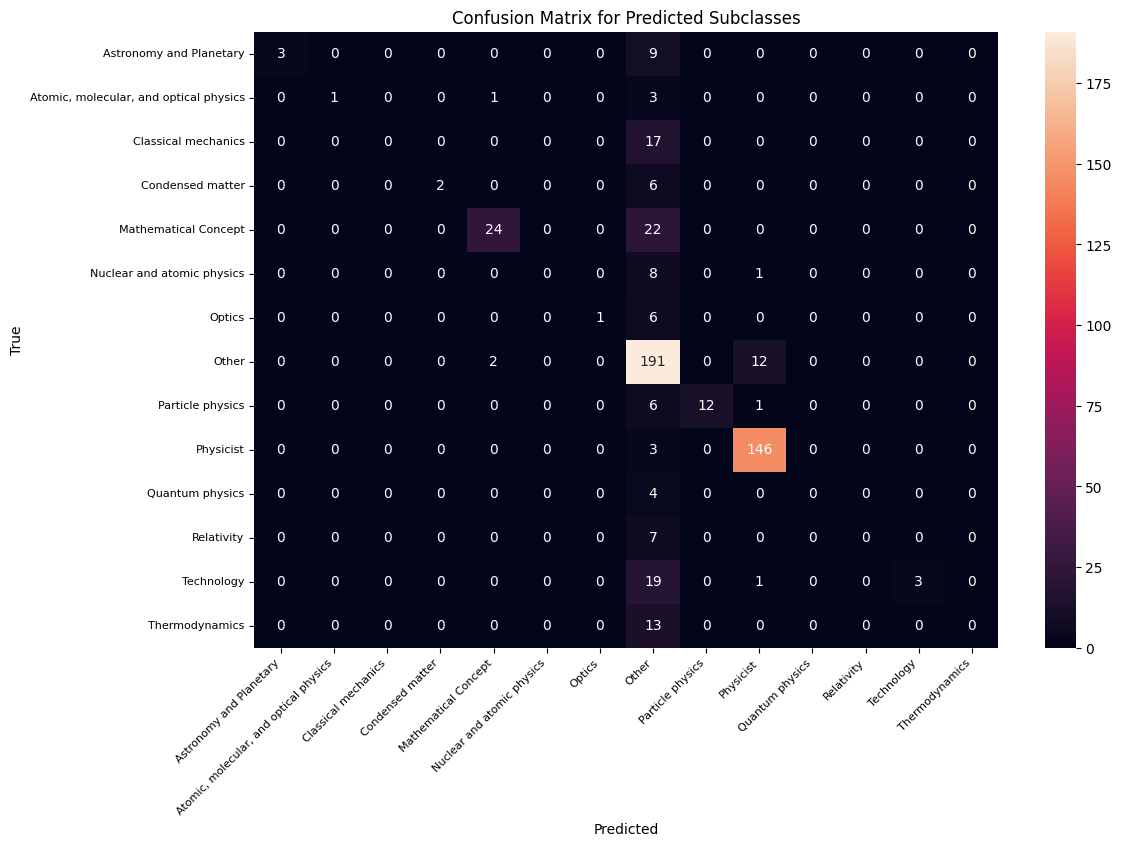

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
cm = confusion_matrix(y_test, predicted, labels=model.classes_)

sns.heatmap(cm, xticklabels=model.classes_,
            yticklabels=model.classes_,
            annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right", fontsize = 8)  # rotate x labels
plt.yticks( fontsize = 8)            
plt.title("Confusion Matrix for Predicted Subclasses")
plt.show()

In [44]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test_vec)
f1 = f1_score(y_test, y_pred, average="weighted")
f1

0.6735025165626167

Creating New Dataset with predicted subclasses and relavent fields from the original jsonl

In [46]:
records = []

with open("has_instance_of.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)

        attrs = obj.get("attributes", {})

        record = {
            "QID": obj.get("QID"),
            "label": obj.get("label"),
            "description": obj.get("description"),

            # attributes (may be missing)
            "instance_of": attrs.get("instance of"),
            "part_of": attrs.get("part of"),
            "subclass_of": attrs.get("subclass of"),
            "facet_of": attrs.get("facet of"),
            "has_characteristic": attrs.get("has characteristic"),
        }

        records.append(record)

df = pd.DataFrame(records)
df


,QID,label,description,instance_of,part_of,subclass_of,facet_of,has_characteristic
0,Q208138,Faraday cage,enclosure of conductive mesh used to block ele...,experiment,None,physical container,None,None
1,Q33198,string theory,physical theory of quantized one-dimensional o...,branch of physics,None,theoretical physics,None,None
2,Q2027476,Anatoli Bugorski,Russian scientist involved in an accident with...,human,None,None,None,None
3,Q177045,second law of thermodynamics,law of physics stating that systems spontaneou...,law of thermodynamics,thermodynamics,None,None,None
4,Q2164598,Wardenclyffe Tower,early experimental wireless transmission stati...,laboratory,None,None,None,None
...,...,...,...,...,...,...,...,...
2776,Q7442523,Sebastian Seung,American physicist,human,None,None,None,None
2777,Q1898912,Mario Livio,Romanian-born Israeli–American astrophysicist ...,human,None,None,None,None
2778,Q3212744,La Science et l'Hypothèse / Henri Poincaré,work by French mathematician Henri Poincaré,written work,None,None,None,None
2779,Q2376736,history of thermodynamics,aspect of history,aspect of history,None,None,None,None


In [48]:
def build_text(row):
    fields = [
        row["description"],
        row["instance_of"],
        row["part_of"],
        row["subclass_of"],
        row["facet_of"],
        row["has_characteristic"],
    ]
    return " ".join([str(f) for f in fields if pd.notnull(f)])

df["model_text"] = df.apply(build_text, axis=1)
df


,QID,label,description,instance_of,part_of,subclass_of,facet_of,has_characteristic,model_text
0,Q208138,Faraday cage,enclosure of conductive mesh used to block ele...,experiment,None,physical container,None,None,enclosure of conductive mesh used to block ele...
1,Q33198,string theory,physical theory of quantized one-dimensional o...,branch of physics,None,theoretical physics,None,None,physical theory of quantized one-dimensional o...
2,Q2027476,Anatoli Bugorski,Russian scientist involved in an accident with...,human,None,None,None,None,Russian scientist involved in an accident with...
3,Q177045,second law of thermodynamics,law of physics stating that systems spontaneou...,law of thermodynamics,thermodynamics,None,None,None,law of physics stating that systems spontaneou...
4,Q2164598,Wardenclyffe Tower,early experimental wireless transmission stati...,laboratory,None,None,None,None,early experimental wireless transmission stati...
...,...,...,...,...,...,...,...,...,...
2776,Q7442523,Sebastian Seung,American physicist,human,None,None,None,None,American physicist human
2777,Q1898912,Mario Livio,Romanian-born Israeli–American astrophysicist ...,human,None,None,None,None,Romanian-born Israeli–American astrophysicist ...
2778,Q3212744,La Science et l'Hypothèse / Henri Poincaré,work by French mathematician Henri Poincaré,written work,None,None,None,None,work by French mathematician Henri Poincaré wr...
2779,Q2376736,history of thermodynamics,aspect of history,aspect of history,None,None,None,None,aspect of history aspect of history


In [50]:
X_all = vectorizer.transform(df["model_text"])

df["predicted_subclass"] = model.predict(X_all)
df


,QID,label,description,instance_of,part_of,subclass_of,facet_of,has_characteristic,model_text,predicted_subclass
0,Q208138,Faraday cage,enclosure of conductive mesh used to block ele...,experiment,None,physical container,None,None,enclosure of conductive mesh used to block ele...,Other
1,Q33198,string theory,physical theory of quantized one-dimensional o...,branch of physics,None,theoretical physics,None,None,physical theory of quantized one-dimensional o...,Other
2,Q2027476,Anatoli Bugorski,Russian scientist involved in an accident with...,human,None,None,None,None,Russian scientist involved in an accident with...,Physicist
3,Q177045,second law of thermodynamics,law of physics stating that systems spontaneou...,law of thermodynamics,thermodynamics,None,None,None,law of physics stating that systems spontaneou...,Other
4,Q2164598,Wardenclyffe Tower,early experimental wireless transmission stati...,laboratory,None,None,None,None,early experimental wireless transmission stati...,Other
...,...,...,...,...,...,...,...,...,...,...
2776,Q7442523,Sebastian Seung,American physicist,human,None,None,None,None,American physicist human,Physicist
2777,Q1898912,Mario Livio,Romanian-born Israeli–American astrophysicist ...,human,None,None,None,None,Romanian-born Israeli–American astrophysicist ...,Physicist
2778,Q3212744,La Science et l'Hypothèse / Henri Poincaré,work by French mathematician Henri Poincaré,written work,None,None,None,None,work by French mathematician Henri Poincaré wr...,Physicist
2779,Q2376736,history of thermodynamics,aspect of history,aspect of history,None,None,None,None,aspect of history aspect of history,Other


In [64]:
gt_map = pd.read_csv("subclasses.csv")
#gt_map.head()

df = df.merge(
    gt_map,
    on="instance_of",
    how="left"
)

In [66]:
df = df.rename(columns={"subclass": "ground_truth_subclass"})
df

,QID,label,description,instance_of,part_of,subclass_of,facet_of,has_characteristic,model_text,predicted_subclass,ground_truth_subclass
0,Q208138,Faraday cage,enclosure of conductive mesh used to block ele...,experiment,None,physical container,None,None,enclosure of conductive mesh used to block ele...,Other,Other
1,Q33198,string theory,physical theory of quantized one-dimensional o...,branch of physics,None,theoretical physics,None,None,physical theory of quantized one-dimensional o...,Other,Other
2,Q2027476,Anatoli Bugorski,Russian scientist involved in an accident with...,human,None,None,None,None,Russian scientist involved in an accident with...,Physicist,Physicist
3,Q177045,second law of thermodynamics,law of physics stating that systems spontaneou...,law of thermodynamics,thermodynamics,None,None,None,law of physics stating that systems spontaneou...,Other,Thermodynamics
4,Q2164598,Wardenclyffe Tower,early experimental wireless transmission stati...,laboratory,None,None,None,None,early experimental wireless transmission stati...,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...
2777,Q7442523,Sebastian Seung,American physicist,human,None,None,None,None,American physicist human,Physicist,Physicist
2778,Q1898912,Mario Livio,Romanian-born Israeli–American astrophysicist ...,human,None,None,None,None,Romanian-born Israeli–American astrophysicist ...,Physicist,Physicist
2779,Q3212744,La Science et l'Hypothèse / Henri Poincaré,work by French mathematician Henri Poincaré,written work,None,None,None,None,work by French mathematician Henri Poincaré wr...,Physicist,Other
2780,Q2376736,history of thermodynamics,aspect of history,aspect of history,None,None,None,None,aspect of history aspect of history,Other,Other


In [68]:
final_cols = [
    "QID",
    "label",
    "description",
    "instance_of",
    "part_of",
    "subclass_of",
    "facet_of",
    "has_characteristic",
    "predicted_subclass",
    "ground_truth_subclass"
]

final_df = df[final_cols]

final_df.to_csv("articles_with_predictions.csv", index=False)
